## 🔧 Chargement des bibliothèques nécessaires
Nous commençons par importer les bibliothèques nécessaires pour le traitement, l’analyse et la visualisation des données.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Option d'affichage : montrer toutes les colonnes
pd.set_option('display.max_columns', None)

## 📂 Chargement du dataset brut
Nous chargeons le fichier Excel contenant le dataset original, puis nous affichons les premières lignes pour avoir un aperçu du contenu.

In [3]:
# Définir le chemin vers le fichier
chemin_fichier = "../datasets/raw_dataset.xlsx"

# Chargement du fichier Excel
df = pd.read_excel(chemin_fichier)

# Aperçu des 5 premières lignes
df.head()

,Sample_Type,bind,CertControlStore,CertOpenStore,closesocket,CoCreateInstance,CoCreateInstanceEx,CoGetClassObject,CoInitializeEx,CoInitializeSecurity,connect,ControlService,CopyFileW,CoUninitialize,CreateActCtxW,CreateDirectoryW,CreateProcessInternalW,CreateRemoteThreadEx,CreateThread,CreateToolhelp32Snapshot,CryptAcquireContextA,CryptAcquireContextW,CryptCreateHash,CryptDecodeObjectEx,CryptDecrypt,CryptEncrypt,CryptExportKey,CryptHashData,DecryptMessage,DeleteFileW,DeviceIoControl,DrawTextExA,DrawTextExW,EnumServicesStatusW,EnumWindows,FindFirstFileExW,FindResourceA,FindResourceExA,FindResourceExW,FindResourceW,FindWindowA,FindWindowExA,FindWindowExW,FindWindowW,GetAdaptersAddresses,getaddrinfo,GetAddrInfoW,GetAsyncKeyState,GetBestInterfaceEx,GetComputerNameA,GetComputerNameW,GetCursorPos,GetDiskFreeSpaceExW,GetDiskFreeSpaceW,GetFileAttributesExW,GetFileAttributesW,GetFileInformationByHandle,GetFileInformationByHandleEx,GetFileSize,GetFileSizeEx,GetFileType,GetFileVersionInfoExW,GetFileVersionInfoSizeExW,GetFileVersionInfoSizeW,GetFileVersionInfoW,GetForegroundWindow,GetKeyboardState,GetKeyState,GetNativeSystemInfo,GetShortPathNameW,getsockname,GetSystemDirectoryA,GetSystemDirectoryW,GetSystemInfo,GetSystemMetrics,GetSystemTimeAsFileTime,GetSystemWindowsDirectoryA,GetSystemWindowsDirectoryW,GetTempPathW,GetTimeZoneInformation,GetUserNameA,GetUserNameExW,GetUserNameW,GetVolumeNameForVolumeMountPointW,GetVolumePathNamesForVolumeNameW,GetVolumePathNameW,GlobalMemoryStatus,GlobalMemoryStatusEx,HttpOpenRequestA,HttpQueryInfoA,HttpSendRequestA,HttpSendRequestW,InternetCloseHandle,InternetConnectA,InternetCrackUrlA,InternetCrackUrlW,InternetGetConnectedState,InternetOpenA,InternetQueryOptionA,InternetReadFile,InternetSetOptionA,ioctlsocket,IsDebuggerPresent,IWbemServices_ExecQuery,LdrGetDllHandle,LdrGetProcedureAddress,LdrLoadDll,LdrUnloadDll,LoadResource,LoadStringA,LoadStringW,LookupAccountSidW,LookupPrivilegeValueW,Module32NextW,MoveFileWithProgressW,NetShareEnum,NtAllocateVirtualMemory,NtClose,NtCreateFile,NtCreateKey,NtCreateMutant,NtCreateSection,NtCreateThreadEx,NtDelayExecution,NtDeleteKey,NtDeviceIoControlFile,NtDuplicateObject,NtEnumerateKey,NtEnumerateValueKey,NtFreeVirtualMemory,NtGetContextThread,NtMapViewOfSection,NtOpenDirectoryObject,NtOpenFile,NtOpenKey,NtOpenKeyEx,NtOpenMutant,NtOpenProcess,NtOpenSection,NtOpenThread,NtProtectVirtualMemory,NtQueryAttributesFile,NtQueryDirectoryFile,NtQueryFullAttributesFile,NtQueryInformationFile,NtQueryKey,NtQueryMultipleValueKey,NtQuerySystemInformation,NtQueryValueKey,NtReadFile,NtReadVirtualMemory,NtResumeThread,NtSetContextThread,NtSetInformationFile,NtSetValueKey,NtSuspendThread,NtTerminateProcess,NtUnmapViewOfSection,NtWriteFile,NtWriteVirtualMemory,ObtainUserAgentString,OleInitialize,OpenSCManagerA,OpenSCManagerW,OpenServiceA,OpenServiceW,OutputDebugStringA,PRF,Process32FirstW,Process32NextW,ReadProcessMemory,recv,RegCloseKey,RegCreateKeyExA,RegCreateKeyExW,RegDeleteKeyA,RegDeleteKeyW,RegDeleteValueA,RegDeleteValueW,RegEnumKeyExA,RegEnumKeyExW,RegEnumKeyW,RegEnumValueA,RegEnumValueW,RegOpenKeyExA,RegOpenKeyExW,RegQueryInfoKeyA,RegQueryInfoKeyW,RegQueryValueExA,RegQueryValueExW,RegSetValueExA,RegSetValueExW,RemoveDirectoryA,RemoveDirectoryW,SearchPathW,select,send,SendNotifyMessageW,sendto,SetEndOfFile,SetErrorMode,SetFileAttributesW,SetFileInformationByHandle,SetFilePointer,SetFilePointerEx,SetFileTime,setsockopt,SetStdHandle,SetUnhandledExceptionFilter,SetWindowsHookExW,ShellExecuteExW,SHGetFolderPathW,SHGetSpecialFolderLocation,shutdown,SizeofResource,socket,Thread32Next,timeGetTime,UuidCreate,WriteConsoleA,WriteConsoleW,WriteProcessMemory,WSARecv,WSASend,WSASocketW,WSAStartup,unique_domains_contacted,ransomware_signatures_detected,dropped_files_count,HKEY_LOCAL_MACHINE\SOFTWARE\MICROSOFT\Cryptography\,HKEY_LOCAL_MACHINE\Software\Policies\Microsoft\MUI\Settings,HKEY_LOCAL_MACHINE\SYSTEM\CurrentControlSet\Services\crypt32,HKEY_LOCAL_MACHINE\System\CurrentControlSet\Control

## 📏 Dimensions et types de données
Affichons le nombre de lignes, de colonnes, et les types de données afin d’avoir une idée globale de la structure du dataset.

In [4]:
# Afficher les dimensions
print("Nombre de lignes (échantillons) :", df.shape[0])
print("Nombre de colonnes (features + classe) :", df.shape[1])

# Afficher les types de données
df.info()

Nombre de lignes (échantillons) : 1042
Nombre de colonnes (features + classe) : 248
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Columns: 248 entries, Sample_Type to HKEY_LOCAL_MACHINE\SYSTEM\Setup\SystemSetupInProgress
dtypes: int64(247), object(1)
memory usage: 2.0+ MB


## 🕳️ Vérification des valeurs manquantes
On s’assure qu’il n’y a pas de colonnes contenant des valeurs nulles, ce qui pourrait nuire à l’apprentissage des modèles.


In [ ]:
# Afficher le total des valeurs nulles par colonne
valeurs_nulles = df.isnull().sum()
valeurs_nulles[valeurs_nulles > 0]

Series([], dtype: int64)

## 🧬 Distribution des classes (Ransomware vs Goodware)
Nous vérifions la répartition des échantillons par type (`Sample_Type`) pour anticiper un éventuel déséquilibre dans les classes.


In [6]:
df['Sample_Type'].value_counts()

Sample_Type
G    524
R    518
Name: count, dtype: int64

## 📊 Visualisation de la répartition des classes
Ce graphique en barres permet de visualiser la proportion de ransomwares (`R`) et de goodwares (`G`) dans le dataset.

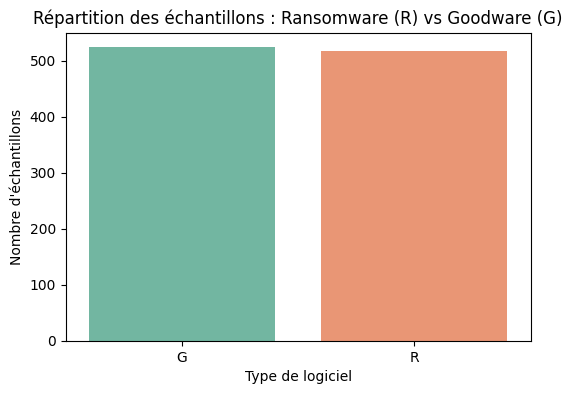

In [7]:
# Créer le graphique
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sample_Type', hue='Sample_Type', palette='Set2', legend=False)
plt.title("Répartition des échantillons : Ransomware (R) vs Goodware (G)")
plt.xlabel("Type de logiciel")
plt.ylabel("Nombre d'échantillons")

# Sauvegarde
plt.savefig("../visuals/repartition_classes.png", dpi=300, bbox_inches='tight')
plt.show()

## 🧹 Détection et suppression des colonnes inutiles
Nous identifions les colonnes qui ne contiennent qu’une seule valeur (par exemple, que des zéros) et nous les supprimons, car elles n’apportent aucune information utile aux modèles de machine learning.


In [8]:
# Détection des colonnes avec une seule valeur unique (souvent des zéros)
colonnes_inutiles = [col for col in df.columns if df[col].nunique() == 1]

print(f"Nombre de colonnes inutiles détectées : {len(colonnes_inutiles)}")
print("Colonnes supprimées :", colonnes_inutiles)

# Suppression
df.drop(columns=colonnes_inutiles, inplace=True)


Nombre de colonnes inutiles détectées : 1
Colonnes supprimées : ['HKEY_CURRENT_USER\\Software\\Microsoft\\CommandProcessor']


## 🔄 Encodage de la variable cible
Nous remplaçons les valeurs catégorielles `R` et `G` de la colonne `Sample_Type` par des valeurs numériques binaires, puis nous supprimons la colonne originale.


In [9]:
# Création de la nouvelle colonne binaire
df['Label'] = df['Sample_Type'].map({'R': 1, 'G': 0})

# Suppression de l'ancienne colonne
df.drop(columns=['Sample_Type'], inplace=True)

# Vérification
df[['Label']].value_counts()

Label
0        524
1        518
Name: count, dtype: int64

## ⚠️ Suppression des colonnes quasi-nulles
Nous identifions et supprimons les colonnes utilisées dans moins de 1% des échantillons (soit moins de 10 occurrences non nulles).


In [11]:
# Seuil d'occurrence minimale (1%)
seuil_min = int(0.01 * len(df))

# Colonnes avec moins de 'seuil_min' échantillons non nuls
colonnes_rares = [col for col in df.columns if col != 'Label' and (df[col] > 0).sum() < seuil_min]

print(f"Colonnes rares détectées : {len(colonnes_rares)}")
print(colonnes_rares[:10])  # afficher les 10 premières

# Suppression
df.drop(columns=colonnes_rares, inplace=True)

Colonnes rares détectées : 5
['DecryptMessage', 'EnumServicesStatusW', 'NtQueryMultipleValueKey', 'ObtainUserAgentString', 'sendto']


## 📏 Dimensions finales après nettoyage avancé
Nous vérifions combien de colonnes (features) ont été conservées dans le dataset après nettoyage renforcé.


In [12]:
print("Dimensions finales du dataset :", df.shape)


Dimensions finales du dataset : (1042, 242)


## 💾 Sauvegarde finale du dataset nettoyé (version avancée)
Nous enregistrons la version finale du dataset nettoyé dans le dossier `datasets/` pour les prochaines étapes (EDA, Feature Engineering, Modélisation).


In [14]:
df.to_csv("../datasets/final_clean_dataset.csv", index=False)